
# Champions League Data — Unsupervised Learning

## Description
For soccer fans: analysis of **Goals**, **Assists**, **Attack**, **Defence**, **Passing**, **Field Control**, and **Goalkeeper Data** for the **UEFA Champions League 2021-22** season.

> The UEFA Champions League is an annual club football competition organised by the Union of European Football Associations (UEFA) and contested by top-division European clubs.


### Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


### Load the Datasets

In [2]:

attempts_ds = pd.read_csv('../data/attempts.csv', index_col=0)
defend_ds = pd.read_csv('../data/defending.csv', index_col=0)
disciplinary_ds = pd.read_csv('../data/disciplinary.csv', index_col=0)
distributon_ds = pd.read_csv('../data/distributon.csv', index_col=0)
key_ds = pd.read_csv('../data/key_stats.csv', index_col=0)


### Merge the Datasets

L’objectif ici est de rassembler des sources hétérogènes en vue d’une analyse intégrée.
Les fichiers sont fusionnés selon trois colonnes communes : `player_name`, `club` et `position`.  
Cette étape produit un seul tableau synthétique où chaque joueur est représenté par une ligne unique contenant l’ensemble de ses indicateurs statistiques.  
L’utilisation de `groupby(...).first()` garantit qu’un joueur n’apparaît qu’une seule fois, même s’il était présent dans plusieurs fichiers sources.

In [3]:

commun_col = ['player_name', 'club', 'position']
dfs = [attempts_ds, defend_ds, disciplinary_ds, distributon_ds, key_ds]
df = pd.concat(dfs, ignore_index=True).groupby(commun_col, as_index=False).first()


### Data Cleaning

In [4]:

df = df.drop(df[df["position"] == "Forward"].index)
df = df.drop(df[df["position"] == "Goalkeeper"].index)
df = df.fillna(0)


C:\Users\orent\AppData\Local\Temp\ipykernel_5772\2970188737.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Deux opérations principales sont effectuées :

1. Suppression de certaines positions de jeu (Forward, Goalkeeper, Midfielder).  
   Cela permet de restreindre l’analyse à un sous-ensemble de joueurs, probablement pour des comparaisons plus homogènes.
2. Remplacement des valeurs manquantes (`NaN`) par des zéros afin d’éviter des erreurs lors des traitements numériques ultérieurs.

Cette étape vise à obtenir un jeu de données propre et complet.

### Feature Selection

In [5]:

df_used = df.select_dtypes(include=np.number)


sel = VarianceThreshold(threshold=0.01)
X = sel.fit_transform(df_used)

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)


scaler = StandardScaler()
X_reduced = scaler.fit_transform(X_pca)



Seules les variables numériques sont conservées, car les algorithmes de clustering exigent des données quantitatives.  
Ensuite, un **StandardScaler** est appliqué pour normaliser les variables.  
Cette étape est cruciale afin de donner le même poids à toutes les caractéristiques, indépendamment de leur échelle d’origine.
Nous avons également supprimer les variables qui ont des variances trop élevés

### Clustering

**Méthode du coude** 

Utilisation de la méthode du coude pour choisir le nombre de clusters par calcul de l'inertie
On prendra $k_{max}$ = 8 car s'est le nombre de personne maximale à vocation défensive dans une équipe (4 def - 4 mil ou 3 def - 5 mil, ou 5 def - 3 mil)

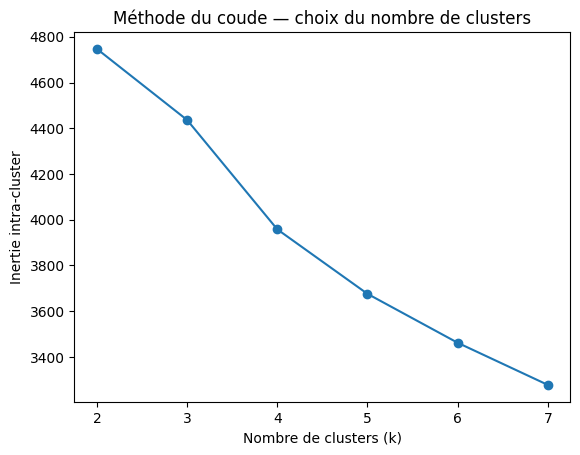

In [6]:
# Choix du nombre de clusters avec la méthode du coude
inertias = []
for k in range(2, 8): ##Le nombre 8 a été choisi ici pour couvrir les 8 positions en défense et du milieu de terrain
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X_reduced)
    inertias.append(km.inertia_)

plt.plot(range(2, 8), inertias, marker='o')
plt.title("Méthode du coude — choix du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.show()

**Rangement en clusters**

Nous allons donc ranger les points dans les 4 clusters déterminés à la méthode des coudes ce qui va nous permettre de redéfinir les positions des joueurs.

In [7]:

# K-Means
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
df_used['kmeans_cluster'] = kmeans.fit_predict(X_reduced)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_used['dbscan_cluster'] = dbscan.fit_predict(X_reduced)

# Agglomerative
agg_clustering = AgglomerativeClustering(n_clusters=3)
df_used['agg_cluster'] = agg_clustering.fit_predict(X_reduced)


Trois algorithmes d’apprentissage non supervisé sont appliqués :

- **K-Means** : partitionne les observations en un nombre fixe de clusters (ici, 4).  
- **DBSCAN** : identifie les regroupements en fonction de la densité, sans nécessiter de spécifier le nombre de clusters.  
- **Agglomerative Clustering** : approche hiérarchique qui regroupe les individus de manière successive en fonction de leur proximité.

Cette comparaison permet d’évaluer différentes approches de segmentation des joueurs.


### Evaluation (Silhouette Scores)

In [8]:

kmeans_score = silhouette_score(X_reduced, df_used['kmeans_cluster'])
dbscan_score = silhouette_score(X_reduced, df_used['dbscan_cluster'])
agg_score = silhouette_score(X_reduced, df_used['agg_cluster'])

print('K-Means Score:', kmeans_score)
print('DBSCAN Score:', dbscan_score)
print('Agglomerative Score:', agg_score)


K-Means Score: 0.18800901609872475
DBSCAN Score: 0.08650851670822737
Agglomerative Score: 0.1275932357682163


Le **Silhouette Score** mesure la qualité du regroupement.  
Une valeur proche de 1 indique des clusters bien séparés, tandis qu’une valeur proche de 0 suggère des groupes qui se chevauchent.  
Cette étape permet de comparer objectivement la performance des trois méthodes de clustering appliquées.
On peut donc voir que le clustering n'est pas efficace. Il nous faut donc utiliser la méthode du PCA afin de le rendre plus fin

### PCA for Visualization

In [9]:

pca = PCA(n_components=2)
coords = pca.fit_transform(X_reduced)
df_used['pca1'], df_used['pca2'] = coords[:, 0], coords[:, 1]


Une **Analyse en Composantes Principales (PCA)** est réalisée pour projeter les données sur deux axes principaux.  
Cela permet de représenter visuellement les clusters dans un plan bidimensionnel tout en conservant l’essentiel de la variance des données.

### Plotting the Clusters

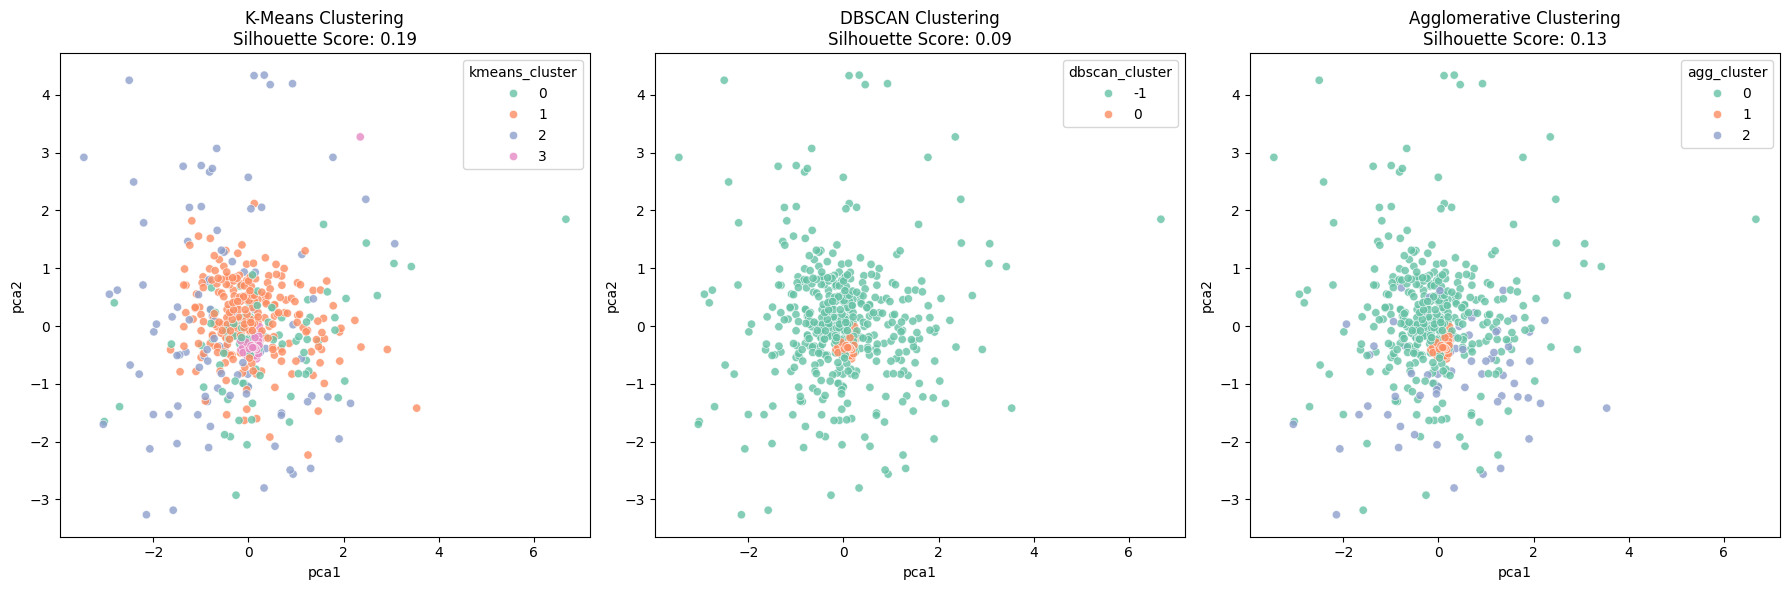

In [10]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=df_used, x='pca1', y='pca2', hue='kmeans_cluster', palette='Set2', alpha=0.8, ax=axes[0])
axes[0].set_title(f'K-Means Clustering\nSilhouette Score: {kmeans_score:.2f}')

sns.scatterplot(data=df_used, x='pca1', y='pca2', hue='dbscan_cluster', palette='Set2', alpha=0.8, ax=axes[1])
axes[1].set_title(f'DBSCAN Clustering\nSilhouette Score: {dbscan_score:.2f}')

sns.scatterplot(data=df_used, x='pca1', y='pca2', hue='agg_cluster', palette='Set2', alpha=0.8, ax=axes[2])
axes[2].set_title(f'Agglomerative Clustering\nSilhouette Score: {agg_score:.2f}')

plt.tight_layout()
plt.show()


### Cluster Profiles

In [11]:

kmeans_profile = df_used.groupby('kmeans_cluster').mean(numeric_only=True)
dbscan_profile = df_used.groupby('dbscan_cluster').mean(numeric_only=True)
agg_profile = df_used.groupby('agg_cluster').mean(numeric_only=True)

kmeans_profile.round(2).T.head(10), dbscan_profile.round(2).T.head(10), agg_profile.round(2).T.head(10)


(kmeans_cluster           0      1      2     3
 total_attempts        4.66   2.87   6.82  0.66
 on_target             1.59   0.94   2.01  0.18
 off_target            1.79   1.25   2.81  0.27
 blocked               1.28   0.68   2.00  0.21
 match_played          6.02   4.93   8.03  2.43
 balls_recoverd       17.62  17.50  33.31  3.05
 tackles               5.50   4.44   9.82  0.97
 t_won                 2.51   1.98   4.46  0.39
 t_lost                2.99   2.46   5.36  0.58
 clearance_attempted   5.14   7.17  14.37  0.99,
 dbscan_cluster          -1     0
 total_attempts        4.06  0.63
 on_target             1.29  0.20
 off_target            1.69  0.27
 blocked               1.09  0.17
 match_played          5.82  2.24
 balls_recoverd       20.97  1.92
 tackles               5.85  0.55
 t_won                 2.63  0.21
 t_lost                3.21  0.34
 clearance_attempted   8.31  0.76,
 agg_cluster              0     1      2
 total_attempts        4.13  0.64   3.87
 on_target    


### Summary
Finalement, l'apprentissage supervisé à des limites très concrètes pour la détermination des profils de joueurs défensifs. En effet les clusteurs ont tendance à se superposer ce qui se reflète au travers du score de silhouette des 3 méthodes utilisé (K_means, DBSCAN ou encore Aggregate). Il faudrait pouvoir déterminer des composantes principales plus pertinantes que celle déterminé dans ce notebook
